# Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import joblib

import time
import os

# Import Data

In [2]:
def any_name_that_you_want(data):
    # print(mean(data))
    print(data)

In [3]:
def import_data(file_path):
    # Read data from the specified file path
    df_raw=pd.read_csv(file_path)

    # Return the imported DataFrame
    return df_raw

# Cleaning Data

# Feature Engineering 

In [4]:
def calculate_alt_change(df):

    # Add new column with calculated Altitude Change  
    df['Alt(m)_change'] = df['Alt(m)'].diff().fillna(0)
    
    # Remove outliers 
    # Set the threshold value for filtering
    alt_threshold = 20
    
    # Filter the DataFrame based on the absolute value of 'Alt(m)_change' column
    df = df[df['Alt(m)_change'].abs() <= alt_threshold]
    
    return df 

# option to add log file later on
# print shape before and after outlier detection and removal 

In [5]:
def plot_alt_changes(df):
    
    # Create a histogram plot
    plt.hist(df['Alt(m)_change'], 
             bins=20, 
             color='skyblue', 
             edgecolor='black')
    
    #Add labels and title
    plt.xlabel('Altitude (m)')
    plt.ylabel('Frequency')
    plt.title('Altitude Changes')
    
    #Show the plot
    plt.show()

In [6]:
def calculate_speed_change(df):

    # Add new column with calculated Speed Change  
    df['Speed(m/s)_change'] = df['Speed(m/s)'].diff().fillna(0)

    # Remove outliers     
    # Set the threshold value for filtering
    threshold_speed = 3
    
    # Filter the DataFrame based on the absolute value of 'Speed(m/s)_change' column
    df = df[df['Speed(m/s)_change'].abs() <= threshold_speed]

    return df     
    
    # option to add log file later on
    # print shape before and after outlier detection and removal 

In [7]:
def plot_speed_changes(df):
    
    # Create a histogram plot
    plt.hist(df['Speed(m/s)_change'], 
             bins=20, 
             color='skyblue', 
             edgecolor='black')
    
    #Add labels and title
    plt.xlabel('Speed Change (m/s)')
    plt.ylabel('Frequency')
    plt.title('Speed Changes')
    
    #Show the plot
    plt.show()

In [8]:
def calculate_course_change(df):

    # Add new column with calculated Course Change  
    df['Course_change'] = df['Course'].diff().fillna(0)

    return df

    # option to add log file later on
    # print shape before and after outlier detection and removal 

In [9]:
def convert_datetime(df):
    
    # Convert 'Timestamp' column to datetime format 
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ns')

    return df

# Prediction

In [10]:
def select_features(df):

    features_to_use = ['accelX(g)', 'accelY(g)', 'accelZ(g)', 'accelUserX(g)', 'accelUserY(g)',
       'accelUserZ(g)', 'gyroX(rad/s)', 'gyroY(rad/s)', 'gyroZ(rad/s)',
       'Roll(rads)', 'Pitch(rads)', 'Yaw(rads)', 'Lat', 'Long', 'Speed(m/s)',
       'HorizontalAccuracy(m)', 'VerticalAccuracy(m)', 'Course', 'calMagX(µT)',
       'calMagY(µT)', 'calMagZ(µT)', 'Alt(m)_change',
       'Speed(m/s)_change', 'Course_change']
    
    X=df[features_to_use]

    return X 

In [11]:
def load_model(file_path_to_model):
    
    # Load the saved model
    return joblib.load(file_path_to_model)


In [12]:
def show_hyperparameters(model):
    # show hyperparameters
    return model.get_params()
    

In [13]:
def predict_on_features(model, df, features):

    predictions=model.predict(features)

    df['predicted']=predictions

    return df
    

# Mapping and Plotting

In [29]:
def plot_prediction(df, plot_title='Predictions'):
    # Check if 'Timestamp' column exists and is in datetime format
    if 'Timestamp' in df.columns and pd.api.types.is_datetime64_any_dtype(df['Timestamp']):
        # Create a scatter plot for Altitude over Time, colored by 'predicted' class
        fig = px.scatter(df, x='Timestamp', y='Alt(m)', color='predicted',
                         labels={'Alt(m)': 'Altitude (m)'},
                         title=plot_title,
                         color_discrete_map={0: 'blue', 1: 'red'})

        fig.update_traces(marker=dict(size=8),
                          selector=dict(mode='markers'))

        # Customize the legend
        fig.update_layout(
            legend_title_text='Status',
            width=1000,
            height=600
        )

        fig.for_each_trace(lambda trace: trace.update(name='Not on the lift' if trace.name == 0 else 'On the lift'))

        # Show the plot
        fig.show()
    else:
        print("Warning: DataFrame's 'Timestamp' column is not in datetime format and must be converted first.")

In [15]:
def plot_total_alt_over_time(df, plot_title='Total Tracked Altitude Over Time'):

    # Create a line plot using Plotly
    fig = go.Figure()
    
    # Add a trace for altitude over time
    fig.add_trace(go.Scatter(x=df['Timestamp'], 
                             y=df['Alt(m)'],
                             mode='lines', 
                             name='Altitude'))
    
    # Update layout
    fig.update_layout(title=plot_title,
                      xaxis_title='Timestamp',
                      yaxis_title='Altitude (m)')
    
    # Show plot
    fig.show()

# Prediction steps in one function 

In [38]:
# use this to predict on a csv that already has all data points 
def predict_on_data(path_to_csv_file, file_path_to_model):

    # Load the data
    df = pd.read_csv(path_to_csv_file)
    
    # Preprocess and feature engineering
    df = calculate_alt_change(df)
    df = calculate_speed_change(df)
    df = calculate_course_change(df)
    df = convert_datetime(df)
    
    # Feature selection
    features = select_features(df)
    
    # Load the model
    rfc = joblib.load(file_path_to_model)
    
    # Make predictions
    df = predict_on_features(rfc, df, features)
    
    # Plot predictions
    plot_prediction(df)



# Real time prediction function 

##### This is the hot stuff to work on :)

In [17]:
def fetch_and_process_data(path_to_csv_file, chunk_size=60, wait_time=2):  

    # Load the dataset
    df_with_all_rows = pd.read_csv(path_to_csv_file)

    # Calculate the total number of chunks
    total_chunks = len(df_with_all_rows) // chunk_size

    # Initialize an empty list to store all calculations
    all_calculations = pd.DataFrame()
    
    for i in range(total_chunks):
        # Fetch a chunk of 60 observations
        start_index = i * chunk_size
        end_index = start_index + chunk_size
        data_chunk = df_with_all_rows.iloc[start_index:end_index]
        
        if len(data_chunk) > 0:
  
            # Append the processed chunk to the list of all calculations
            all_calculations = pd.concat([all_calculations, data_chunk], ignore_index=True)

            # Print the first few rows of the processed chunk for demonstration
        #     print(f"Processed chunk {i+1}.")
        #     print(data_chunk.head())

            # funct(all_calculations)    

            # Preprocess and feature engineering
            df = calculate_alt_change(all_calculations)
            df = calculate_speed_change(df)
            df = calculate_course_change(df)
            df = convert_datetime(df)

            print(df.shape)
                
            # # Feature selection
            # features = select_features(df)
                
            # # Make predictions
            # df = predict_on_features(rfc, df, features)
            

            # print(len(data_chunk))
            # print(len(all_calculations))
        
        else:
            print(f"No more data to process in chunk {i+1}.")

        
        
        # Wait for declared wait_time before processing the next chunk
        time.sleep(wait_time)



# To do before going for one of the above mentioned options

Make sure that specify the paths and other variables needed

In [18]:
# These are the default values used in the function fetch_and_process_data, change if needed 
chunk_size=60
wait_time=2

In [19]:
# # Specify the file path to directory with data to predict on
# path_to_csv_file='/Users/ze/Documents/Coding/Projects/2024/alturos/data/processed/df_310_labeled_on_lift_v4.csv'

In [73]:
# Specify the file path to directory with data to predict on
path_to_df_95='/Users/ze/Documents/Coding/Projects/2024/alturos/data/raw/v5_20230407_091351_95m.csv'
path_to_df_310='/Users/ze/Documents/Coding/Projects/2024/alturos/data/raw/v5_20230408_082538_310m.csv'
path_to_df_Natschen_18='/Users/ze/Documents/Coding/Projects/2024/alturos/data/raw/Natschen-2024-02-04_12-04-18.csv'
path_to_df_Natschen_46='/Users/ze/Documents/Coding/Projects/2024/alturos/data/raw/Natschen-2024-02-04_12-01-46.csv'

In [70]:
# Specify the file path to pre-trained model 
path_to_model_0_1 = '/Users/ze/Documents/Coding/Projects/2024/alturos/models/rf_v_0.1.pkl'
path_to_model_0_2 = '/Users/ze/Documents/Coding/Projects/2024/alturos/models/rf_v_0.2.pkl'
path_to_model_0_3 = '/Users/ze/Documents/Coding/Projects/2024/alturos/models/rf_v_0.3.pkl'
path_to_model_0_4 = '/Users/ze/Documents/Coding/Projects/2024/alturos/models/rf_v_0.4.pkl'
path_to_model_0_5 = '/Users/ze/Documents/Coding/Projects/2024/alturos/models/rf_v_0.5.pkl'

# Option 1: 'Real time' prediction 

In [22]:
# # Call this function to simulate prediction in 'real time'
# fetch_and_process_data(path_to_csv_file, 
#                        chunk_size=60, 
#                        wait_time=0.1)

# Option 2: One step to prediction 

In [74]:
path_to_model=path_to_model_0_3

----- df_95 -----


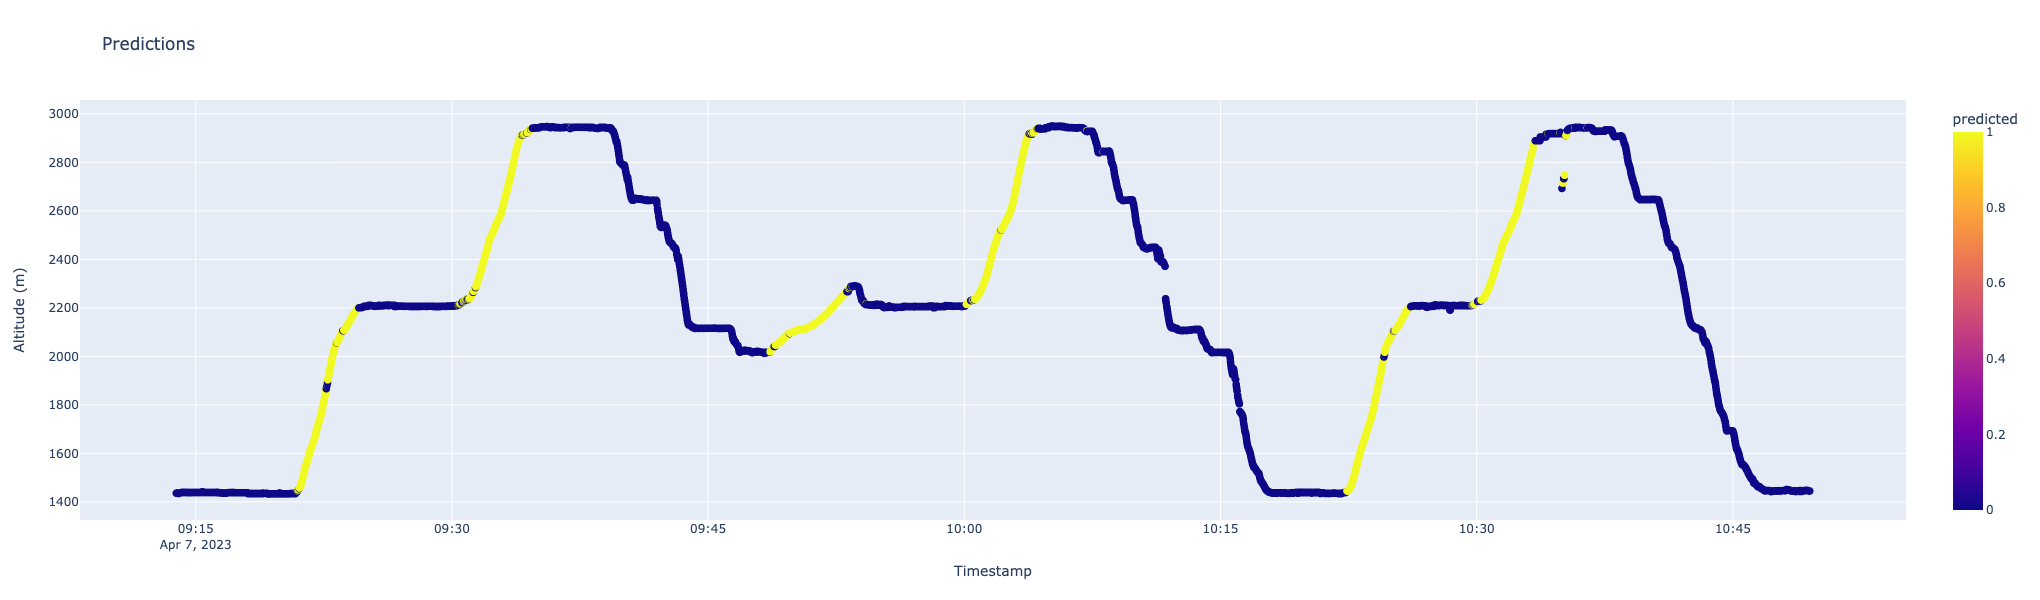

----- df_310 -----


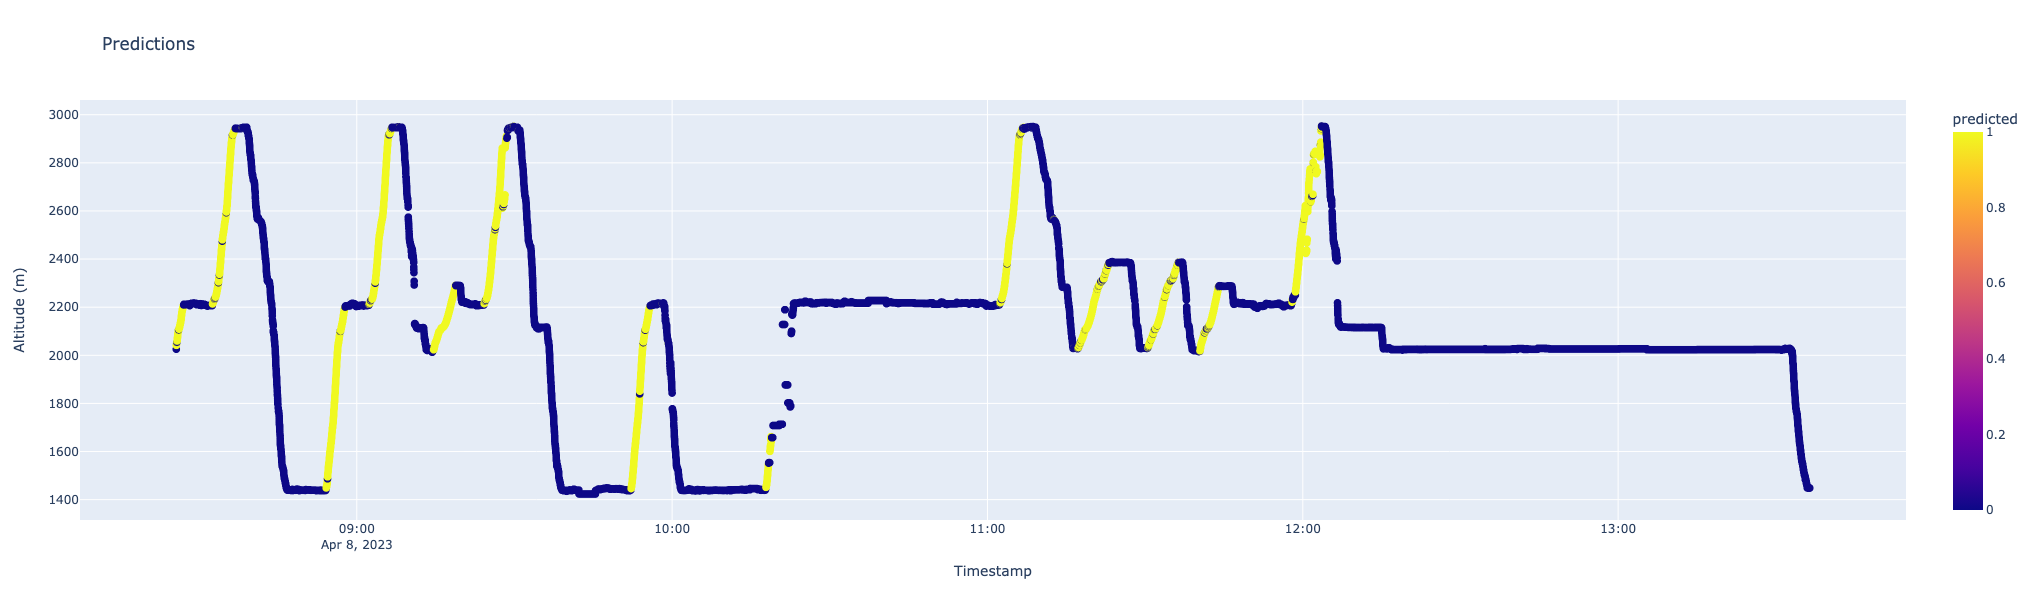

----- df_Natschen_18 -----


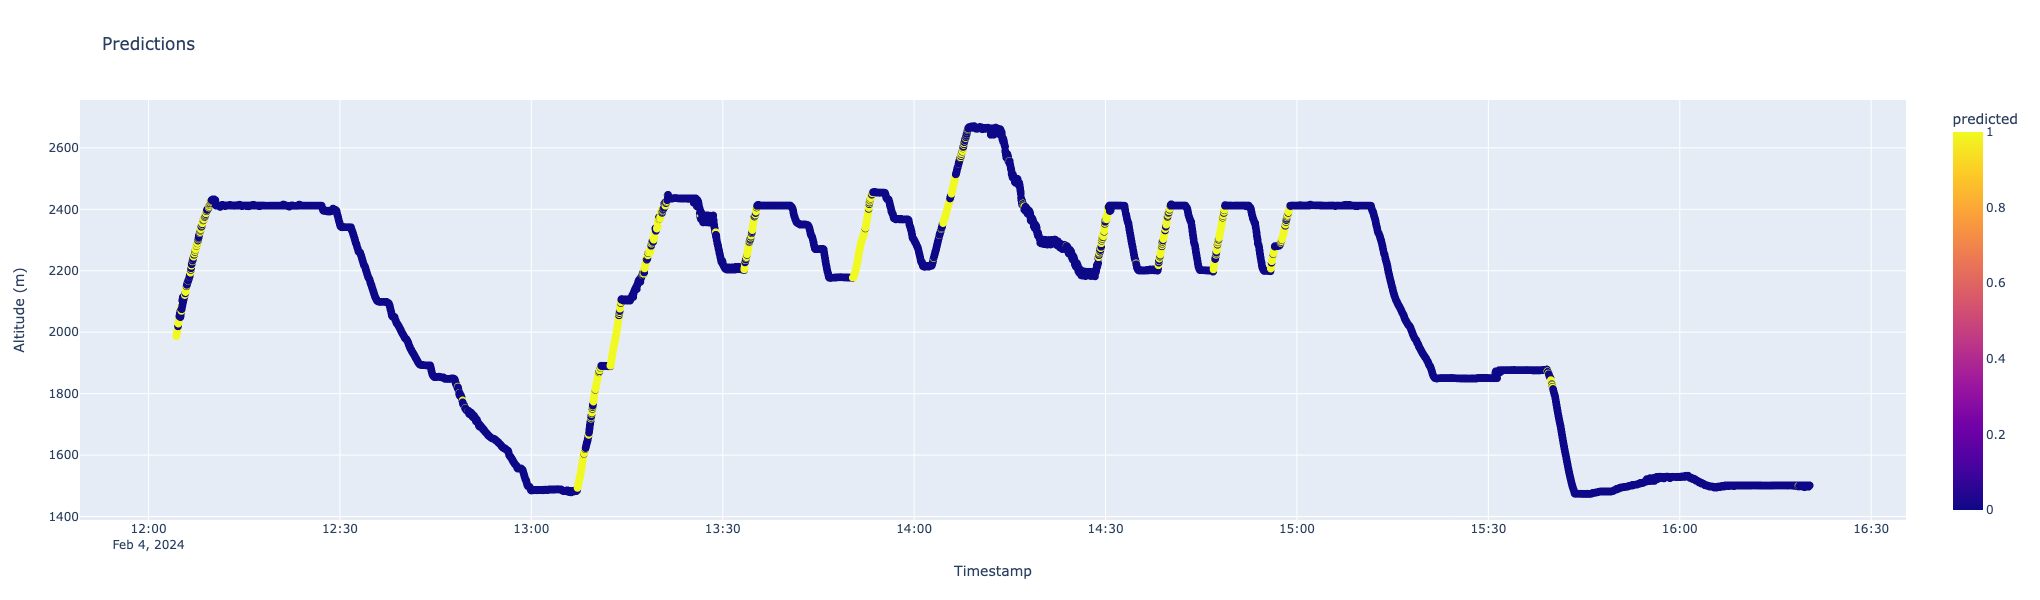

In [72]:
print('----- df_95 -----')
predict_on_data(path_to_df_95, path_to_model)
print('----- df_310 -----')
predict_on_data(path_to_df_310, path_to_model)
print('----- df_Natschen_18 -----')
predict_on_data(path_to_df_Natschen_18, path_to_model)

----- df_Natschen_46 -----


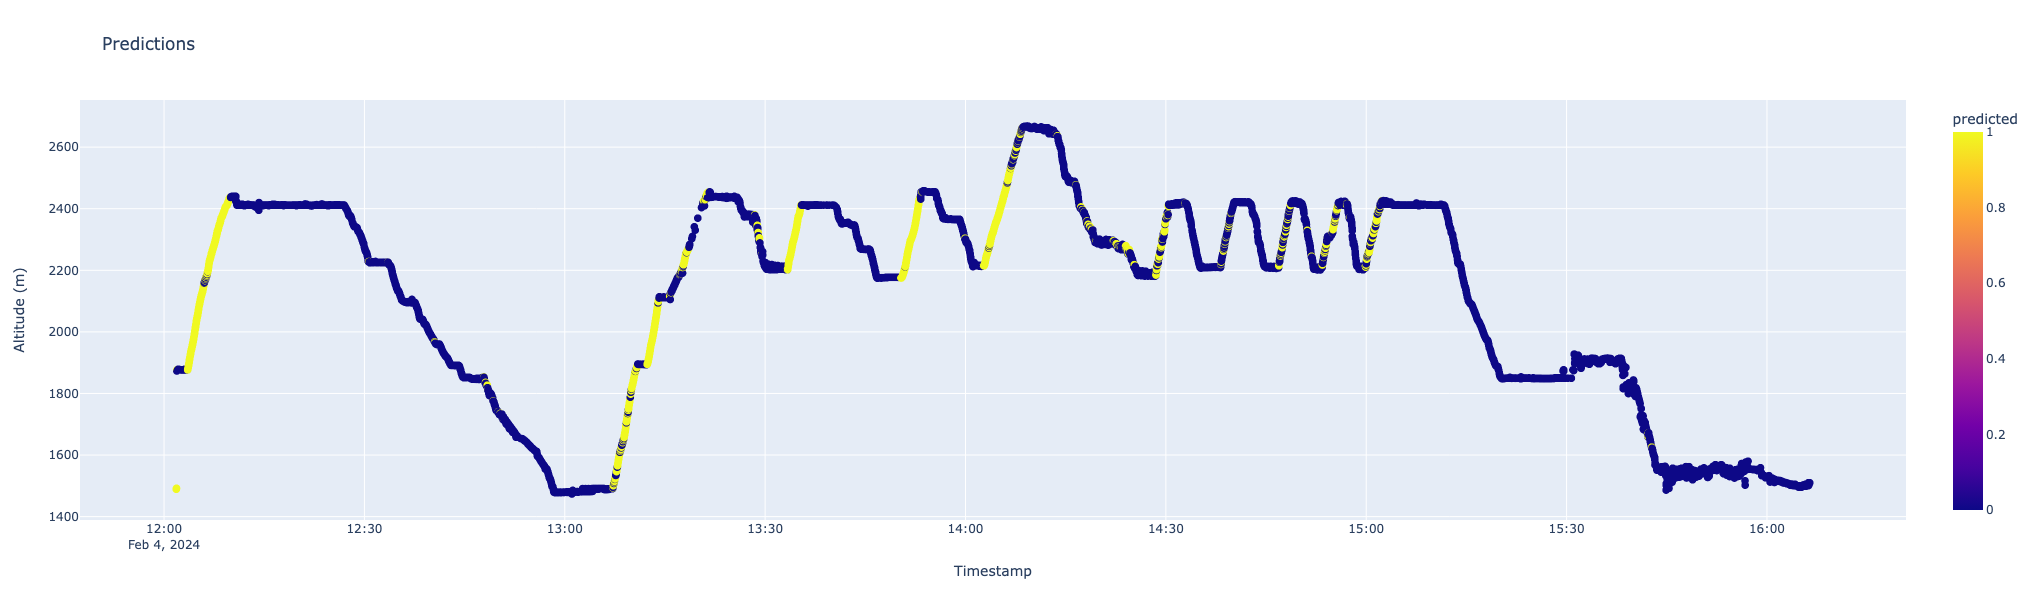

In [75]:
print('----- df_Natschen_46 -----')
predict_on_data(path_to_df_Natschen_46, path_to_model)

# Option 3: Go through everything step by step 

In [ ]:
df_option3=import_data(path_to_csv_file)

In [ ]:
df_option3=calculate_alt_change(df_option3)

In [ ]:
df_option3=calculate_speed_change(df_option3)

In [ ]:
df_option3=calculate_course_change(df_option3)

In [ ]:
df_option3=convert_datetime(df_option3)

In [ ]:
features=select_features(df_option3)

In [ ]:
rfc=load_model(file_path_to_model)

In [ ]:
df_option3=predict_on_features(rfc, df_option3, features)

In [ ]:
plot_prediction(df_option3)

# Option 3: Simulate real time data input 

In [ ]:
# # Load the model
# rfc = joblib.load(file_path_to_model)